<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span><ul class="toc-item"><li><span><a href="#Метрика-качества" data-toc-modified-id="Метрика-качества-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Метрика качества</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Dummy-модель" data-toc-modified-id="Dummy-модель-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Dummy-модель</a></span></li><li><span><a href="#Проверка-модели" data-toc-modified-id="Проверка-модели-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Проверка модели</a></span></li></ul></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для компании, которая разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Описание данных**

Стадии очистки золота:
1. Флотация
2. Очистка
    - первичная
    - вторичная
    
Наименование признаков имеет следующий вид:
[этап].[тип_параметра].[название_параметра]

Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

## Подготовка данных

В первую очередь импортируем необходимые библиотеки и инструменты для исследования.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

Сохраним все датасеты в соответствующих переменных.

In [2]:
df_train = pd.read_csv('gold_recovery_train.csv')
df_test = pd.read_csv('gold_recovery_test.csv')
df_full = pd.read_csv('gold_recovery_full.csv')

Напишем функцию data_info для вывода информации о таблице:
- первые 5 строк
- основная информация о таблице
- % пропусков в каждом столбце
- количество полных дубликатов
- количество дубликатов в столбце date

In [3]:
def data_info(data):
    print('Первые пять строк таблицы:')
    display(data.head().T)
    print()
    print('Основная информация о таблице:')
    data.info()
    print()
    print('Процент пропущенных значений в каждом столбце:')
    display(pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm'))
    print()
    print('Количество полных дубликатов:', data.duplicated().sum())
    print()
    print('Количество дубликатов в столбце date:', data['date'].duplicated().sum())

In [4]:
data_info(df_train)

Первые пять строк таблицы:


,0,1,2,3,4
date,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00,2016-01-15 04:00:00
final.output.concentrate_ag,6.055403,6.029369,6.055926,6.047977,6.148599
final.output.concentrate_pb,9.889648,9.968944,10.213995,9.977019,10.142511
final.output.concentrate_sol,5.507324,5.257781,5.383759,4.858634,4.939416
final.output.concentrate_au,42.19202,42.701629,42.657501,42.689819,42.774141
...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,-498.310211,-500.169983,-500.129135,-499.20164,-501.686727
secondary_cleaner.state.floatbank5_b_air,8.079666,7.984757,8.013877,7.977324,7.894242
secondary_cleaner.state.floatbank5_b_level,-500.470978,-500.582168,-500.517572,-500.255908,-500.356035
secondary_cleaner.state.floatbank6_a_air,14.151341,13.998353,14.028663,14.005551,13.996647



Основная информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                       

,0
date,0.000000
final.output.concentrate_ag,0.010000
final.output.concentrate_pb,0.010000
final.output.concentrate_sol,1.490000
final.output.concentrate_au,0.000000
final.output.recovery,0.000000
final.output.tail_ag,0.000000
final.output.tail_pb,0.710000
final.output.tail_sol,0.040000
final.output.tail_au,0.000000



Количество полных дубликатов: 0

Количество дубликатов в столбце date: 0


In [5]:
data_info(df_test)

Первые пять строк таблицы:


,0,1,2,3,4
date,2016-09-01 00:59:59,2016-09-01 01:59:59,2016-09-01 02:59:59,2016-09-01 03:59:59,2016-09-01 04:59:59
primary_cleaner.input.sulfate,210.800909,215.392455,215.259946,215.336236,199.099327
primary_cleaner.input.depressant,14.993118,14.987471,12.884934,12.006805,10.68253
primary_cleaner.input.feed_size,8.08,8.08,7.786667,7.64,7.53
primary_cleaner.input.xanthate,1.005021,0.990469,0.996043,0.863514,0.805575
primary_cleaner.state.floatbank8_a_air,1398.981301,1398.777912,1398.493666,1399.618111,1401.268123
primary_cleaner.state.floatbank8_a_level,-500.225577,-500.057435,-500.86836,-498.863574,-500.808305
primary_cleaner.state.floatbank8_b_air,1399.144926,1398.055362,1398.860436,1397.44012,1398.128818
primary_cleaner.state.floatbank8_b_level,-499.919735,-499.778182,-499.764529,-499.211024,-499.504543
primary_cleaner.state.floatbank8_c_air,1400.102998,1396.151033,1398.075709,1400.129303,1402.172226



Основная информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-

,0
date,0.000000
primary_cleaner.input.sulfate,0.080000
primary_cleaner.input.depressant,0.090000
primary_cleaner.input.feed_size,0.000000
primary_cleaner.input.xanthate,0.080000
primary_cleaner.state.floatbank8_a_air,0.000000
primary_cleaner.state.floatbank8_a_level,0.000000
primary_cleaner.state.floatbank8_b_air,0.000000
primary_cleaner.state.floatbank8_b_level,0.000000
primary_cleaner.state.floatbank8_c_air,0.000000



Количество полных дубликатов: 0

Количество дубликатов в столбце date: 0


In [6]:
data_info(df_full)

Первые пять строк таблицы:


,0,1,2,3,4
date,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00,2016-01-15 04:00:00
final.output.concentrate_ag,6.055403,6.029369,6.055926,6.047977,6.148599
final.output.concentrate_pb,9.889648,9.968944,10.213995,9.977019,10.142511
final.output.concentrate_sol,5.507324,5.257781,5.383759,4.858634,4.939416
final.output.concentrate_au,42.19202,42.701629,42.657501,42.689819,42.774141
...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,-498.310211,-500.169983,-500.129135,-499.20164,-501.686727
secondary_cleaner.state.floatbank5_b_air,8.079666,7.984757,8.013877,7.977324,7.894242
secondary_cleaner.state.floatbank5_b_level,-500.470978,-500.582168,-500.517572,-500.255908,-500.356035
secondary_cleaner.state.floatbank6_a_air,14.151341,13.998353,14.028663,14.005551,13.996647



Основная информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                       

,0
date,0.000000
final.output.concentrate_ag,0.010000
final.output.concentrate_pb,0.010000
final.output.concentrate_sol,1.090000
final.output.concentrate_au,0.000000
final.output.recovery,0.000000
final.output.tail_ag,0.010000
final.output.tail_pb,0.520000
final.output.tail_sol,0.030000
final.output.tail_au,0.000000



Количество полных дубликатов: 0

Количество дубликатов в столбце date: 0


В данных нет дубликатов, все признаки имеют корректный тип данных.

Данные поделены на обучающую и тестовую выборки в соотношении 75:25.

В тестовой выборке отсутствует примерно 1/3 признаков, которые есть в исходном датасете (full).

Наибольшее количество пропусков содержится в столбце secondary_cleaner.output.tail_sol. Так как этот столбец отсутствует в тестовой выборке, он нам не понадобится для исследования. Соответственно, нам не принципиально, какими значениями заполнить пропуски в данном столбце. В остальных столбцах количество пропусков не превышает 2.5%. Заполним пропуски мотодом интерполяции.

In [7]:
df_train = df_train.interpolate(limit_direction='both')
df_test = df_test.interpolate(limit_direction='both')
df_full = df_full.interpolate(limit_direction='both')

Проверим на обучающей выборке корректность расчета эффективности обогащения золота. Для этого напишем функцию для расчета эффективности обогащения (calc_recovery) и сравним получившиеся значения со столбцом rougher.output.recovery.

In [8]:
numerator = df_train['rougher.output.concentrate_au'] * (df_train['rougher.input.feed_au'] - df_train['rougher.output.tail_au'])
denominator = df_train['rougher.input.feed_au'] * (df_train['rougher.output.concentrate_au'] - df_train['rougher.output.tail_au'])


calc_recovery = 100 * numerator / denominator

In [9]:
print('Среднее абсолютное отклонение:', mean_absolute_error(df_train['rougher.output.recovery'], calc_recovery))

Среднее абсолютное отклонение: 1.1131451184435918e-14


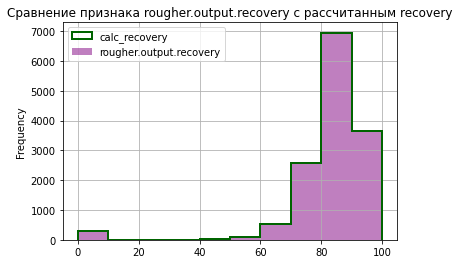

In [10]:
calc_recovery.plot(kind='hist', histtype='step', color='darkgreen', linewidth=2, grid=True, legend=True, label='calc_recovery')
df_train['rougher.output.recovery'].plot(kind='hist', color='purple', alpha=0.5, grid=True, legend=True)
plt.title('Сравнение признака rougher.output.recovery с рассчитанным recovery')
plt.show()

Среднее абсолютное отклонение минимально, что означает корректность расчета эффективности обогащения золота в обучающей выборке.

Также рассмотрим, какие признаки отсутствуют в тестовой выборке.

In [11]:
set(df_train.columns) - set(df_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Все признаки относятся к выходным параметрам продукта на различных этапах. Так как данные признаки отсутствуют в тестовой выборке, обучение модели необходимо проводить также без учета данных признаков.

Проведем анализ данных, а затем приведем к соответствию обучающую и тестовую выборки.

## Анализ данных

Рассмотрим распределение веществ (au, ag, pb, sol) на разных этапах очистки - от исходного сырья до финального концентрата.
Напишем функцию, которая выведет график распределения концетрации каждого вещества и медианное значение на каждом этапе.

In [12]:
def concentration_plot(series_1, series_2, series_3, series_4, title):
    f, axs = plt.subplots(ncols=2, figsize=(17, 6))
    series_1.plot(kind='hist', bins=200, grid=True, legend=True, alpha=0.7, subplots=True, ax=axs[0], color='blue')
    series_2.plot(kind='hist', bins=200, grid=True, legend=True, alpha=0.7, subplots=True, ax=axs[0], color='red')
    series_3.plot(kind='hist', bins=200, grid=True, legend=True, alpha=0.7, subplots=True, ax=axs[0], color='green')
    series_4.plot(kind='hist', bins=200, grid=True, legend=True, alpha=0.7, subplots=True, ax=axs[0], color='orange')
    pd.Series([series_1.median(), series_2.median(), series_3.median(), series_4.median()]).plot(kind='bar', grid=True, subplots=True, ax=axs[1], title=title)
    plt.show()

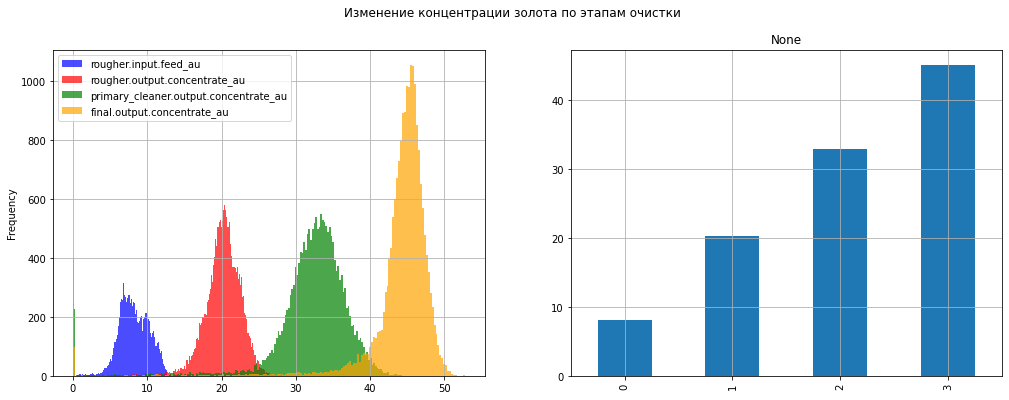

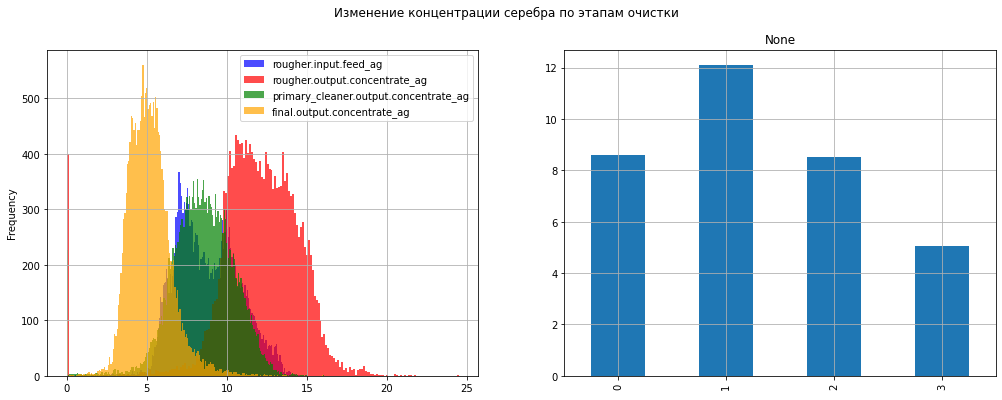

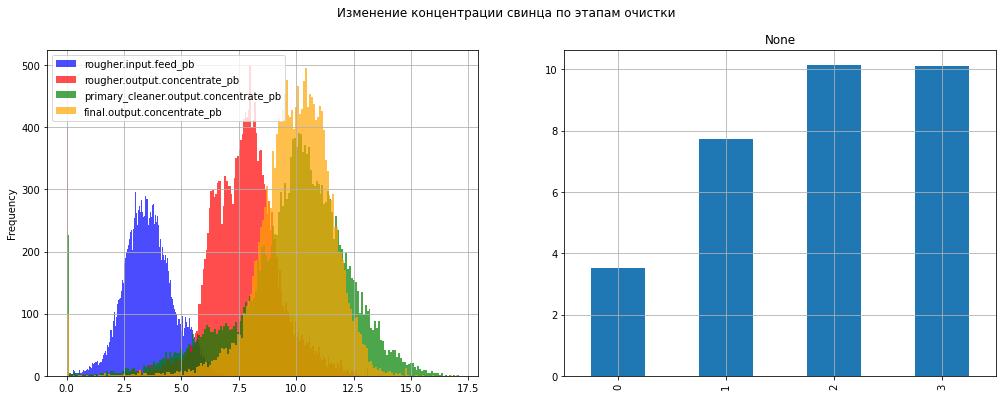

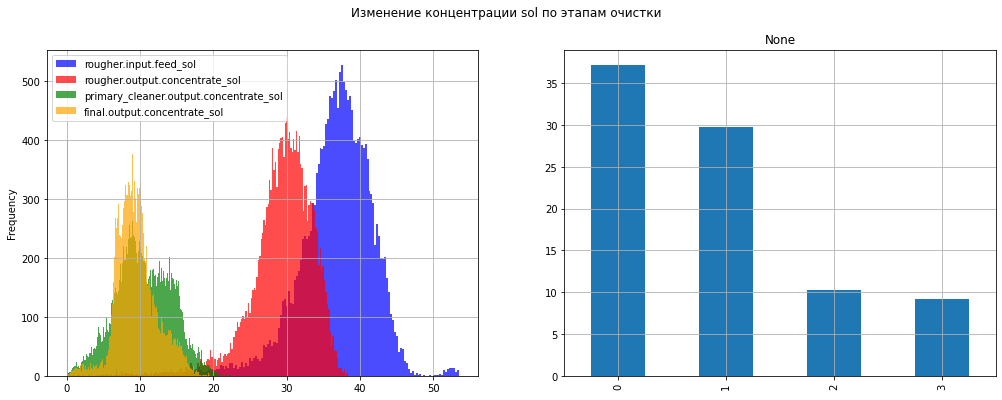

In [13]:
concentration_plot(
    df_full['rougher.input.feed_au'], df_full['rougher.output.concentrate_au'], 
    df_full['primary_cleaner.output.concentrate_au'], df_full['final.output.concentrate_au'], 
    'Изменение концентрации золота по этапам очистки')

concentration_plot(
    df_full['rougher.input.feed_ag'], df_full['rougher.output.concentrate_ag'], 
    df_full['primary_cleaner.output.concentrate_ag'], df_full['final.output.concentrate_ag'], 
    'Изменение концентрации серебра по этапам очистки')

concentration_plot(
    df_full['rougher.input.feed_pb'], df_full['rougher.output.concentrate_pb'], 
    df_full['primary_cleaner.output.concentrate_pb'], df_full['final.output.concentrate_pb'], 
    'Изменение концентрации свинца по этапам очистки')

concentration_plot(
    df_full['rougher.input.feed_sol'], df_full['rougher.output.concentrate_sol'], 
    df_full['primary_cleaner.output.concentrate_sol'], df_full['final.output.concentrate_sol'], 
    'Изменение концентрации sol по этапам очистки')

- Концентрация золота постепенно увеличивается от этапа к этапу.
- Концентрация серебра увеличивается после процесса флотации, после чего постепенно снижается.
- Концентрация свинца постепенно увеличивается в процессе флотации и первичной очистки и не меняетяс в процессе вторичной очистки.
- Концентрация sol постепенно снижается от этапа к этапу.

На графиках распределения также видно, что в данных присутствуют выбросы и аномальные значения. 

Однако все признаки, по которым построены распределения, кроме rougher.input.feed_, отсутствуют в тестовой выборках. Поэтому рассмотрим отдельно только признак rougher.input.feed_ в обучающей и тестовой выборках для каждого вещества.

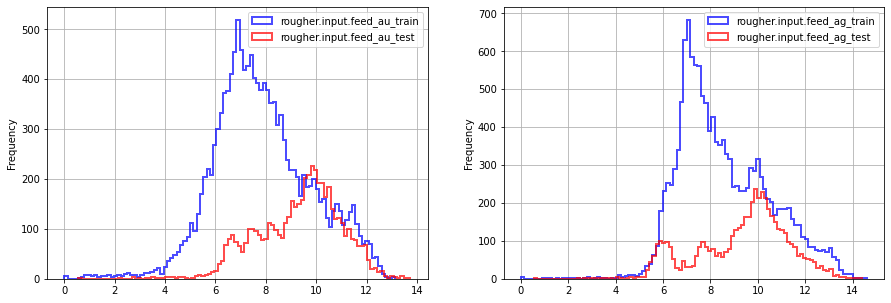

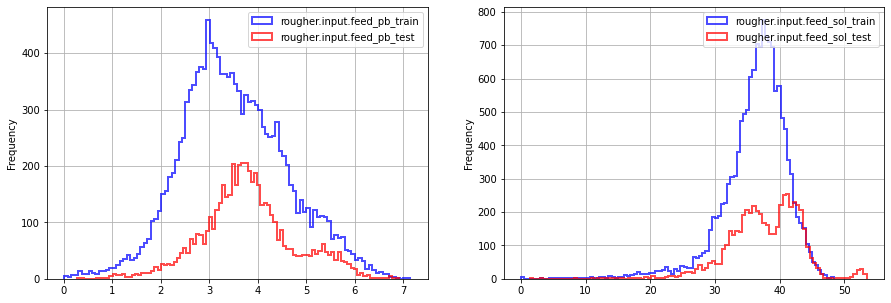

In [14]:
f, axs = plt.subplots(ncols=2, figsize=(15, 5))
df_train['rougher.input.feed_au'].plot(kind='hist', histtype='step', bins=100, grid=True, legend=True, alpha=0.7, color='blue', linewidth=2, subplots=True, ax=axs[0], label='rougher.input.feed_au_train')
df_test['rougher.input.feed_au'].plot(kind='hist', histtype='step', bins=100, grid=True, legend=True, alpha=0.7, color='red', linewidth=2, subplots=True, ax=axs[0], label='rougher.input.feed_au_test')
df_train['rougher.input.feed_ag'].plot(kind='hist', histtype='step', bins=100, grid=True, legend=True, alpha=0.7, color='blue', linewidth=2, subplots=True, ax=axs[1], label='rougher.input.feed_ag_train')
df_test['rougher.input.feed_ag'].plot(kind='hist', histtype='step', bins=100, grid=True, legend=True, alpha=0.7, color='red', linewidth=2, subplots=True, ax=axs[1], label='rougher.input.feed_ag_test')
plt.show()

f, axs = plt.subplots(ncols=2, figsize=(15, 5))
df_train['rougher.input.feed_pb'].plot(kind='hist', histtype='step', bins=100, grid=True, legend=True, alpha=0.7, color='blue', linewidth=2, subplots=True, ax=axs[0], label='rougher.input.feed_pb_train')
df_test['rougher.input.feed_pb'].plot(kind='hist', histtype='step', bins=100, grid=True, legend=True, alpha=0.7, color='red', linewidth=2, subplots=True, ax=axs[0], label='rougher.input.feed_pb_test')
df_train['rougher.input.feed_sol'].plot(kind='hist', histtype='step', bins=100, grid=True, legend=True, alpha=0.7, color='blue', linewidth=2, subplots=True, ax=axs[1], label='rougher.input.feed_sol_train')
df_test['rougher.input.feed_sol'].plot(kind='hist', histtype='step', bins=100, grid=True, legend=True, alpha=0.7, color='red', linewidth=2, subplots=True, ax=axs[1], label='rougher.input.feed_sol_test')
plt.show()

Концентрация свинца распределена нормально. По остальным веществам ограничим распределения, чтобы избавиться от самых редких значений.

In [15]:
df_train = df_train[df_train['rougher.input.feed_au'] > 2]
df_test = df_test[df_test['rougher.input.feed_au'] > 2]

df_train = df_train[df_train['rougher.input.feed_ag'] > 4]
df_test = df_test[df_test['rougher.input.feed_ag'] > 4]
                  
df_train = df_train[(df_train['rougher.input.feed_sol'] > 15) & (df_train['rougher.input.feed_sol'] < 50)]
df_test = df_test[(df_test['rougher.input.feed_sol'] > 15) & (df_test['rougher.input.feed_sol'] < 50)]

Теперь рассмотрим размер гранул сырья на обучающей и тестовой выборках. Размеры гранул представлены в признаках rougher.input.feed_size и primary_cleaner.input.feed_size.

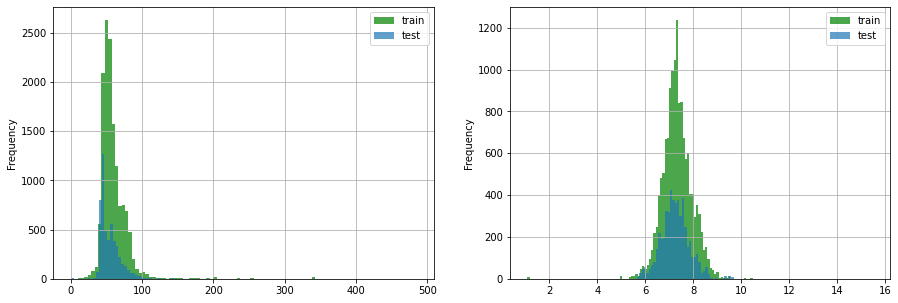

In [16]:
f, axs = plt.subplots(ncols=2, figsize=(15, 5))
df_train['rougher.input.feed_size'].plot(kind='hist', bins=100, grid=True, label='train', legend=True, figsize=(8,5), color='green', alpha=0.7, subplots=True, ax=axs[0])
df_test['rougher.input.feed_size'].plot(kind='hist', bins=100, grid=True, label='test', legend=True, figsize=(8,5), alpha=0.7, subplots=True, ax=axs[0])
df_train['primary_cleaner.input.feed_size'].plot(kind='hist', bins=100, grid=True, label='train', legend=True, figsize=(8,5), color='green', alpha=0.7, subplots=True, ax=axs[1])
df_test['primary_cleaner.input.feed_size'].plot(kind='hist', bins=100, grid=True, label='test', legend=True, figsize=(8,5), alpha=0.7, subplots=True, ax=axs[1])
plt.show()

В данном случае мы также наблюдаем большой разброс редких значений. Ограничим обе выборки.

In [17]:
df_train = df_train[(df_train['rougher.input.feed_size'] > 20) & (df_train['rougher.input.feed_size'] < 120)]
df_test = df_test[(df_test['rougher.input.feed_size'] > 20) & (df_test['rougher.input.feed_size'] < 120)]
df_train = df_train[(df_train['primary_cleaner.input.feed_size'] > 5) & (df_train['primary_cleaner.input.feed_size'] < 10)]
df_test = df_test[(df_test['primary_cleaner.input.feed_size'] > 5) & (df_test['primary_cleaner.input.feed_size'] < 10)]

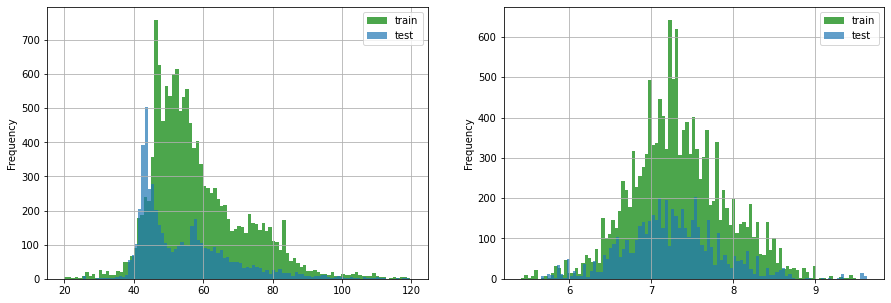

In [18]:
f, axs = plt.subplots(ncols=2, figsize=(15, 5))
df_train['rougher.input.feed_size'].plot(kind='hist', bins=100, grid=True, label='train', legend=True, figsize=(8,5), color='green', alpha=0.7, subplots=True, ax=axs[0])
df_test['rougher.input.feed_size'].plot(kind='hist', bins=100, grid=True, label='test', legend=True, figsize=(8,5), alpha=0.7, subplots=True, ax=axs[0])
df_train['primary_cleaner.input.feed_size'].plot(kind='hist', bins=100, grid=True, label='train', legend=True, figsize=(8,5), color='green', alpha=0.7, subplots=True, ax=axs[1])
df_test['primary_cleaner.input.feed_size'].plot(kind='hist', bins=100, grid=True, label='test', legend=True, figsize=(8,5), alpha=0.7, subplots=True, ax=axs[1])
plt.show()

In [19]:
print(df_train['rougher.input.feed_size'].describe())
print()
print(df_test['rougher.input.feed_size'].describe())
print()
print(df_train['primary_cleaner.input.feed_size'].describe())
print()
print(df_test['primary_cleaner.input.feed_size'].describe())

count    13824.000000
mean        58.346650
std         13.484667
min         20.056099
25%         48.856895
50%         55.096830
75%         65.400005
max        119.664018
Name: rougher.input.feed_size, dtype: float64

count    5119.000000
mean       54.404487
std        13.310012
min        25.334235
25%        43.824316
50%        50.117205
75%        61.249977
max       119.222131
Name: rougher.input.feed_size, dtype: float64

count    13824.000000
mean         7.337592
std          0.582641
min          5.410000
25%          6.976458
50%          7.300000
75%          7.700000
max          9.500000
Name: primary_cleaner.input.feed_size, dtype: float64

count    5119.000000
mean        7.253682
std         0.587480
min         5.650000
25%         6.890000
50%         7.245000
75%         7.590000
max         9.630000
Name: primary_cleaner.input.feed_size, dtype: float64


Распределения размера гранул после флотации на обучающей и тестовой выборках очень похожи.

Распределения размера гранул исходного сырья на обучающей и тестовой выборках отличаются, но несущественно для нашего исследования.

Рассмотрим также суммарную концентрацию всех веществ на каждом этапе. В этот раз построим распределение по обучающей выборке, чтобы посмотреть, какое влияние оказало удаление аномальных значений.

In [20]:
summary_rougher_input = pd.Series(df_train['rougher.input.feed_au'] + df_train['rougher.input.feed_ag'] + df_train['rougher.input.feed_pb'] + df_train['rougher.input.feed_sol'])
summary_rougher_output = pd.Series(df_train['rougher.output.concentrate_au'] + df_train['rougher.output.concentrate_ag'] + df_train['rougher.output.concentrate_pb'] + df_train['rougher.output.concentrate_sol'])
summary_primary_cleaner_output = pd.Series(df_train['primary_cleaner.output.concentrate_au'] + df_train['primary_cleaner.output.concentrate_ag'] + df_train['primary_cleaner.output.concentrate_pb'] + df_train['primary_cleaner.output.concentrate_sol'])
summary_final_output = pd.Series(df_train['final.output.concentrate_au'] + df_train['final.output.concentrate_ag'] + df_train['final.output.concentrate_pb'] + df_train['final.output.concentrate_sol'])

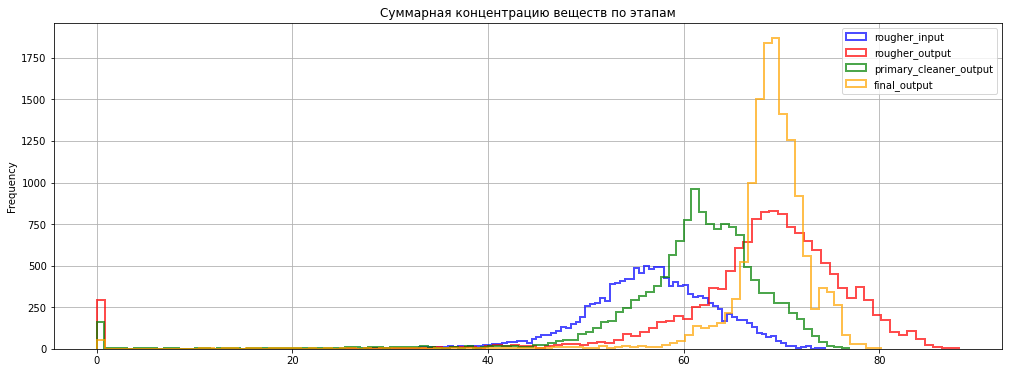

In [21]:
summary_rougher_input.plot(kind='hist', histtype='step', linewidth=2, bins=100, grid=True, legend=True, figsize=(17,6), alpha=0.7, color='blue', label='rougher_input')
summary_rougher_output.plot(kind='hist', histtype='step', linewidth=2, bins=100, grid=True, legend=True, figsize=(17,6), alpha=0.7, color='red', label='rougher_output')
summary_primary_cleaner_output.plot(kind='hist', histtype='step', linewidth=2, bins=100, grid=True, legend=True, figsize=(17,6), alpha=0.7, color='green', label='primary_cleaner_output')
summary_final_output.plot(kind='hist', histtype='step', linewidth=2, bins=100, grid=True, legend=True, figsize=(17,6), alpha=0.7, color='orange', label='final_output')
plt.title('Суммарная концентрацию веществ по этапам')
plt.show()

Наблюдается всплекс нулевых концентраций на всех этапах, кроме входного сырья (т.к. они были удалены ранее). Аналогичные выбросы присутствовали при рассмотрении концентрации веществ по отдельности на исходном датасете. 

Удалим данные аномалии.

In [22]:
df_train = df_train[
    (df_train['rougher.output.concentrate_au'] > 0) & 
    (df_train['rougher.output.concentrate_ag'] > 0) & 
    (df_train['rougher.output.concentrate_pb'] > 0) & 
    (df_train['rougher.output.concentrate_sol'] > 0) &
    (df_train['primary_cleaner.output.concentrate_au'] > 0) & 
    (df_train['primary_cleaner.output.concentrate_ag'] > 0) & 
    (df_train['primary_cleaner.output.concentrate_pb'] > 0) & 
    (df_train['primary_cleaner.output.concentrate_sol'] > 0) & 
    (df_train['final.output.concentrate_au'] > 0) & 
    (df_train['final.output.concentrate_ag'] > 0) & 
    (df_train['final.output.concentrate_pb'] > 0) & 
    (df_train['final.output.concentrate_sol'] > 0)
]

Добавим в тестовую выборку столбцы rougher.output.recovery и final.output.recovery (т.к. они являются целевым признаком для проверки модели), затем удалить из обучающей выборки все столбцы, которые отсутствуют в тестовой.

Изменим индексацию во всех датасетах на столбец date, затем выполним описанные выше действия.

In [23]:
df_train = df_train.set_index('date')
df_test = df_test.set_index('date')
df_full = df_full.set_index('date')

In [24]:
df_test['rougher.output.recovery'] = df_full['rougher.output.recovery']
df_test['final.output.recovery'] = df_full['final.output.recovery']

In [25]:
drop_col = list(set(df_train.columns) - set(df_test.columns))
df_train = df_train.drop(drop_col, axis=1)

Посмотрим на распределение целевых признаков rougher.output.recovery и final.output.recovery.

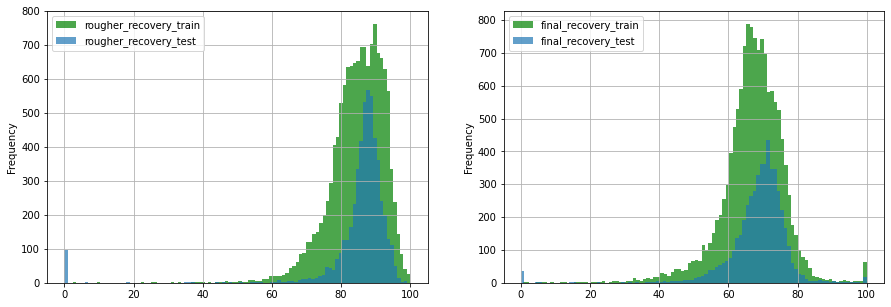

In [26]:
f, axs = plt.subplots(ncols=2, figsize=(15, 5))
df_train['rougher.output.recovery'].plot(kind='hist', bins=100, grid=True, legend=True, figsize=(8,5), color='green', alpha=0.7, subplots=True, ax=axs[0], label='rougher_recovery_train')
df_test['rougher.output.recovery'].plot(kind='hist', bins=100, grid=True, legend=True, figsize=(8,5), alpha=0.7, subplots=True, ax=axs[0], label='rougher_recovery_test')
df_train['final.output.recovery'].plot(kind='hist', bins=100, grid=True, legend=True, figsize=(8,5), color='green', alpha=0.7, subplots=True, ax=axs[1], label='final_recovery_train')
df_test['final.output.recovery'].plot(kind='hist', bins=100, grid=True, legend=True, figsize=(8,5), alpha=0.7, subplots=True, ax=axs[1], label='final_recovery_test')
plt.show()

В распределениях также присутствуют аномальные значения. Удалим их.

In [27]:
df_train = df_train[df_train['rougher.output.recovery'] > 50]
df_test = df_test[df_test['rougher.output.recovery'] > 50]
df_train = df_train[(df_train['final.output.recovery'] > 30) & (df_train['final.output.recovery'] < 90)]
df_test = df_test[(df_test['final.output.recovery'] > 30) & (df_test['final.output.recovery'] < 90)]

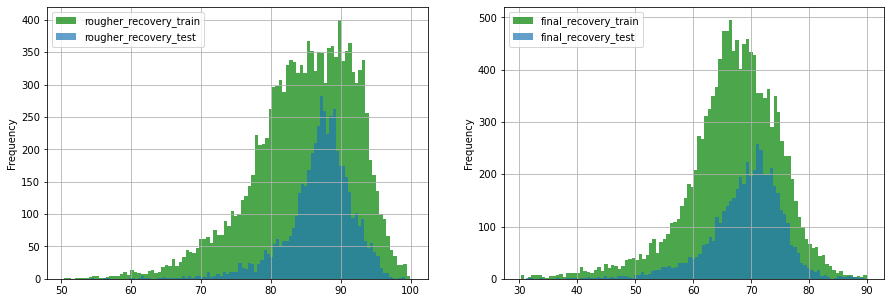

In [28]:
f, axs = plt.subplots(ncols=2, figsize=(15, 5))
df_train['rougher.output.recovery'].plot(kind='hist', bins=100, grid=True, legend=True, figsize=(8,5), color='green', alpha=0.7, subplots=True, ax=axs[0], label='rougher_recovery_train')
df_test['rougher.output.recovery'].plot(kind='hist', bins=100, grid=True, legend=True, figsize=(8,5), alpha=0.7, subplots=True, ax=axs[0], label='rougher_recovery_test')
df_train['final.output.recovery'].plot(kind='hist', bins=100, grid=True, legend=True, figsize=(8,5), color='green', alpha=0.7, subplots=True, ax=axs[1], label='final_recovery_train')
df_test['final.output.recovery'].plot(kind='hist', bins=100, grid=True, legend=True, figsize=(8,5), alpha=0.7, subplots=True, ax=axs[1], label='final_recovery_test')
plt.show()

Теперь распределения приближены к нормальным. Приступим к построению моделей.

## Модель

### Метрика качества ###

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Создадим две функции для ее расчета.

In [29]:
def smape(target, predictions):
    total = 0
    for i in range(len(predictions)):
        total += (2 * (abs(target[i] - predictions[i])) / (abs(target[i]) + abs(predictions[i])))
    smape = total * 100 / len(predictions)
    return smape

smape_score = make_scorer(smape, greater_is_better=False)

def final_smape(rougher_smape, final_smape):
    final_smape = 0.25 * rougher_smape + 0.75 * final_smape
    return final_smape

Разделим обучающую и тестовую выбоки на признаки и 2 целевых признака.

In [30]:
features_train = df_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_rougher_train = df_train['rougher.output.recovery']
target_final_train = df_train['final.output.recovery']

features_test = df_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_rougher_test = df_test['rougher.output.recovery']
target_final_test = df_test['final.output.recovery']

Проведем масштабирование признаков обучающей выборки.

In [31]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)
pd.options.mode.chained_assignment = None

Приступим к обучению моделей.

### Линейная регрессия ###

In [32]:
%%time

model_lr_rougher = LinearRegression()
scores_lr_rougher = cross_val_score(model_lr_rougher, features_train, target_rougher_train, scoring=smape_score, cv=5, n_jobs=-1)
print('Оценка предсказаний rougher.output.recovery', scores_lr_rougher.mean())
print()

model_lr_final = LinearRegression()
scores_lr_final = cross_val_score(model_lr_final, features_train, target_final_train, scoring=smape_score, cv=5, n_jobs=-1)
print('Оценка предсказаний final.output.recovery', scores_lr_final.mean())
print()

print('Итоговый SMAPE для логистической регрессии на обучающей выборке', final_smape(scores_lr_rougher.mean(), scores_lr_final.mean()))
print()

Оценка предсказаний rougher.output.recovery -6.483228400131097

Оценка предсказаний final.output.recovery -9.869854760092938

Итоговый SMAPE для логистической регрессии на обучающей выборке -9.023198170102479

CPU times: user 996 ms, sys: 2.03 s, total: 3.02 s
Wall time: 3.02 s


При обучении логистической регрессии ошибка предсказаний признака final.output.recovery на треть больше ошибки предсказаний признака rougher.output.recovery. Рассмотрим другие модели для сравнения.

### Дерево решений ###

In [33]:
%%time

params_dtr = {'max_depth': range(1, 10)}

model_dtr_rougher = DecisionTreeRegressor(random_state=12345)
grid_dtr_rougher = GridSearchCV(model_dtr_rougher, params_dtr, scoring=smape_score, cv=5, n_jobs=-1)
grid_dtr_rougher.fit(features_train, target_rougher_train)

print('Оценка предсказаний rougher.output.recovery', grid_dtr_rougher.best_score_)
print('Лучшая глубина дерева для rougher.output.recovery', grid_dtr_rougher.best_params_)
print()

model_dtr_final = DecisionTreeRegressor(random_state=12345)
grid_dtr_final = GridSearchCV(model_dtr_final, params_dtr, scoring=smape_score, cv=5, n_jobs=-1)
grid_dtr_final.fit(features_train, target_final_train)

print('Оценка предсказаний final.output.recovery', grid_dtr_final.best_score_)
print('Лучшая глубина дерева для final.output.recovery', grid_dtr_final.best_params_)
print()

print('Итоговый SMAPE для дерева решений на обучающей выборке', final_smape(grid_dtr_rougher.best_score_, grid_dtr_final.best_score_))
print()

Оценка предсказаний rougher.output.recovery -6.40419269536832
Лучшая глубина дерева для rougher.output.recovery {'max_depth': 3}

Оценка предсказаний final.output.recovery -8.635302443537055
Лучшая глубина дерева для final.output.recovery {'max_depth': 1}

Итоговый SMAPE для дерева решений на обучающей выборке -8.077525006494872

CPU times: user 24.2 s, sys: 89.6 ms, total: 24.3 s
Wall time: 24.3 s


При обучении дерева решений ошибки предсказаний обоих признаков немного ниже, чем при использовании логистической регрессии. Итоговая SMAPE также немного ниже.

### Случайный лес ###

In [34]:
%%time

params_rfr = {
    'n_estimators': range(10, 51, 5),
    'max_depth': range(1, 10)
}

model_rfr_rougher = RandomForestRegressor(random_state=12345)
grid_rfr_rougher = GridSearchCV(model_rfr_rougher, params_rfr, scoring=smape_score, cv=5, n_jobs=-1)
grid_rfr_rougher.fit(features_train, target_rougher_train)

print('Оценка предсказаний rougher.output.recovery', grid_rfr_rougher.best_score_)
print('Лучшие параметры случайного леса для rougher.output.recovery', grid_rfr_rougher.best_params_)
print()

model_rfr_final = RandomForestRegressor(random_state=12345)
grid_rfr_final = GridSearchCV(model_rfr_final, params_rfr, scoring=smape_score, cv=5, n_jobs=-1)
grid_rfr_final.fit(features_train, target_final_train)

print('Оценка предсказаний final.output.recovery', grid_rfr_final.best_score_)
print('Лучшие параметры случайного леса для final.output.recovery', grid_rfr_final.best_params_)
print()

print('Итоговый SMAPE для случайного леса на обучающей выборке', final_smape(grid_rfr_rougher.best_score_, grid_rfr_final.best_score_))
print()

Оценка предсказаний rougher.output.recovery -5.875136331799746
Лучшие параметры случайного леса для rougher.output.recovery {'max_depth': 6, 'n_estimators': 40}

Оценка предсказаний final.output.recovery -7.981436004446389
Лучшие параметры случайного леса для final.output.recovery {'max_depth': 4, 'n_estimators': 30}

Итоговый SMAPE для случайного леса на обучающей выборке -7.454861086284728

CPU times: user 1h 2min 16s, sys: 13.4 s, total: 1h 2min 29s
Wall time: 1h 2min 31s


Случайный лес, несмотря на очень высокое время обучения, дает самые низкие значения ошибок. Для того, чтобы удостовериться, что данная модель является лучшей, рассмотрим также константную модель.

### Dummy-модель ###

Для оценки качества наших моделей сравним их результаты с dummy-моделью, которая по всем наблюдениям предсказывает медианное значение целевого признака.

In [35]:
%%time

model_dummy_rougher = DummyRegressor(strategy='median')
scores_dummy_rougher = cross_val_score(model_dummy_rougher, features_train, target_rougher_train, scoring=smape_score, cv=5, n_jobs=-1)
print('Оценка предсказаний rougher.output.recovery', scores_dummy_rougher.mean())
print()

model_dummy_final = DummyRegressor(strategy='median')
scores_dummy_final = cross_val_score(model_dummy_final, features_train, target_final_train, scoring=smape_score, cv=5, n_jobs=-1)
print('Оценка предсказаний final.output.recovery', scores_dummy_final.mean())
print()

print('Итоговый SMAPE для dummy-модели на обучающей выборке', final_smape(scores_dummy_rougher.mean(), scores_dummy_final.mean()))
print()

Оценка предсказаний rougher.output.recovery -7.442152509135115

Оценка предсказаний final.output.recovery -9.45971638092725

Итоговый SMAPE для dummy-модели на обучающей выборке -8.955325412979217

CPU times: user 164 ms, sys: 4.02 ms, total: 168 ms
Wall time: 177 ms


Результаты констатной модели сравнимы с результатами логистической регрессии.

Таким образом, лучшей моделью является случайный лес с подобранными гиперпараметрами. Проверим его на тестовой выборке.

### Проверка модели ###

In [36]:
rougher_test_smape = grid_rfr_rougher.score(features_test, target_rougher_test)
final_test_smape = grid_rfr_final.score(features_test, target_final_test)
final_smape(rougher_test_smape, final_test_smape)

-6.754277702430722

Случайный лес на тестовой выборке показал хороший результат. Значение SMAPE вышло ниже, чем на валидации.